In [ ]:
from dataloaders.loaders import get_dataloaders

print("dataloaders에 들어있는 키:", dataloaders.keys())

ModuleNotFoundError: No module named 'dataloaders'

In [10]:
import sys
import os
sys.path.append(os.path.abspath('..'))

import pandas as pd
import torch
import torch.nn as nn
from timm import create_model
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import numpy as np
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')

import random
import numpy as np

def seed_everything(seed=28):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(28)

# ✅ 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_root = f'../data/train2'
test_csv_path = '../data/test.csv'
sample_sub_path = '../data/sample_submission.csv'
save_dir = '../submissions'
base_save_dir = '../checkpoints'
num_epochs = 35
batch_size = 32

best_model_name = 'vit_base_patch16_224'

# ✅ 전체 데이터로 재학습
from dataloaders.loaders import get_dataloaders
from models.train_utils import train_one_epoch

dataloaders = get_dataloaders(data_root, batch_size=batch_size, val_ratio=0.0, return_path=False)
train_loader = dataloaders[best_model_name]['train']
class_names = dataloaders[best_model_name]['classes']
num_classes = len(class_names)

model = create_model(best_model_name, pretrained=True, num_classes=num_classes).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

print("🔁 전체 학습 데이터로 재학습 시작")
for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
    print(f"📘 Epoch {epoch + 1} 🔹 Training Loss: {train_loss:.4f} 🔹 Learning Rate: {scheduler.get_last_lr()[0]:.6f}")
    scheduler.step()

# ✅ 모델 저장
os.makedirs(base_save_dir, exist_ok=True)
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
model_path = os.path.join(base_save_dir, f'{best_model_name}_{timestamp}.pth')
torch.save(model.state_dict(), model_path)
print(f"💾 모델 저장 완료: {model_path}")

model.eval()

# ✅ 테스트 전처리
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# ✅ 테스트 데이터 로드
test_df = pd.read_csv(test_csv_path)
submission_template = pd.read_csv(sample_sub_path)
submission_class_names = submission_template.columns.tolist()[1:]

# ✅ 예측
results = []
with torch.no_grad():
    for _, row in tqdm(test_df.iterrows(), total=len(test_df), desc='🔍 테스트셋 예측'):
        img_path = os.path.join('../data', row['img_path'])
        image = Image.open(img_path).convert('RGB')

        input_tensor = transform(image).unsqueeze(0).to(device)
        output = model(input_tensor)
        prob = torch.softmax(output, dim=1).squeeze().cpu().numpy()
        results.append(prob)

# ✅ 제출 파일 생성
submission_df = pd.DataFrame(results, columns=class_names)
submission_df.insert(0, 'ID', test_df['ID'])

os.makedirs(save_dir, exist_ok=True)
submission_path = os.path.join(save_dir, f'submission_{best_model_name}_{timestamp}.csv')
submission_df.to_csv(submission_path, index=False)

print(f"✅ 제출 파일 저장 완료: {submission_path}\n")


KeyError: 'vit_base_patch16_224'

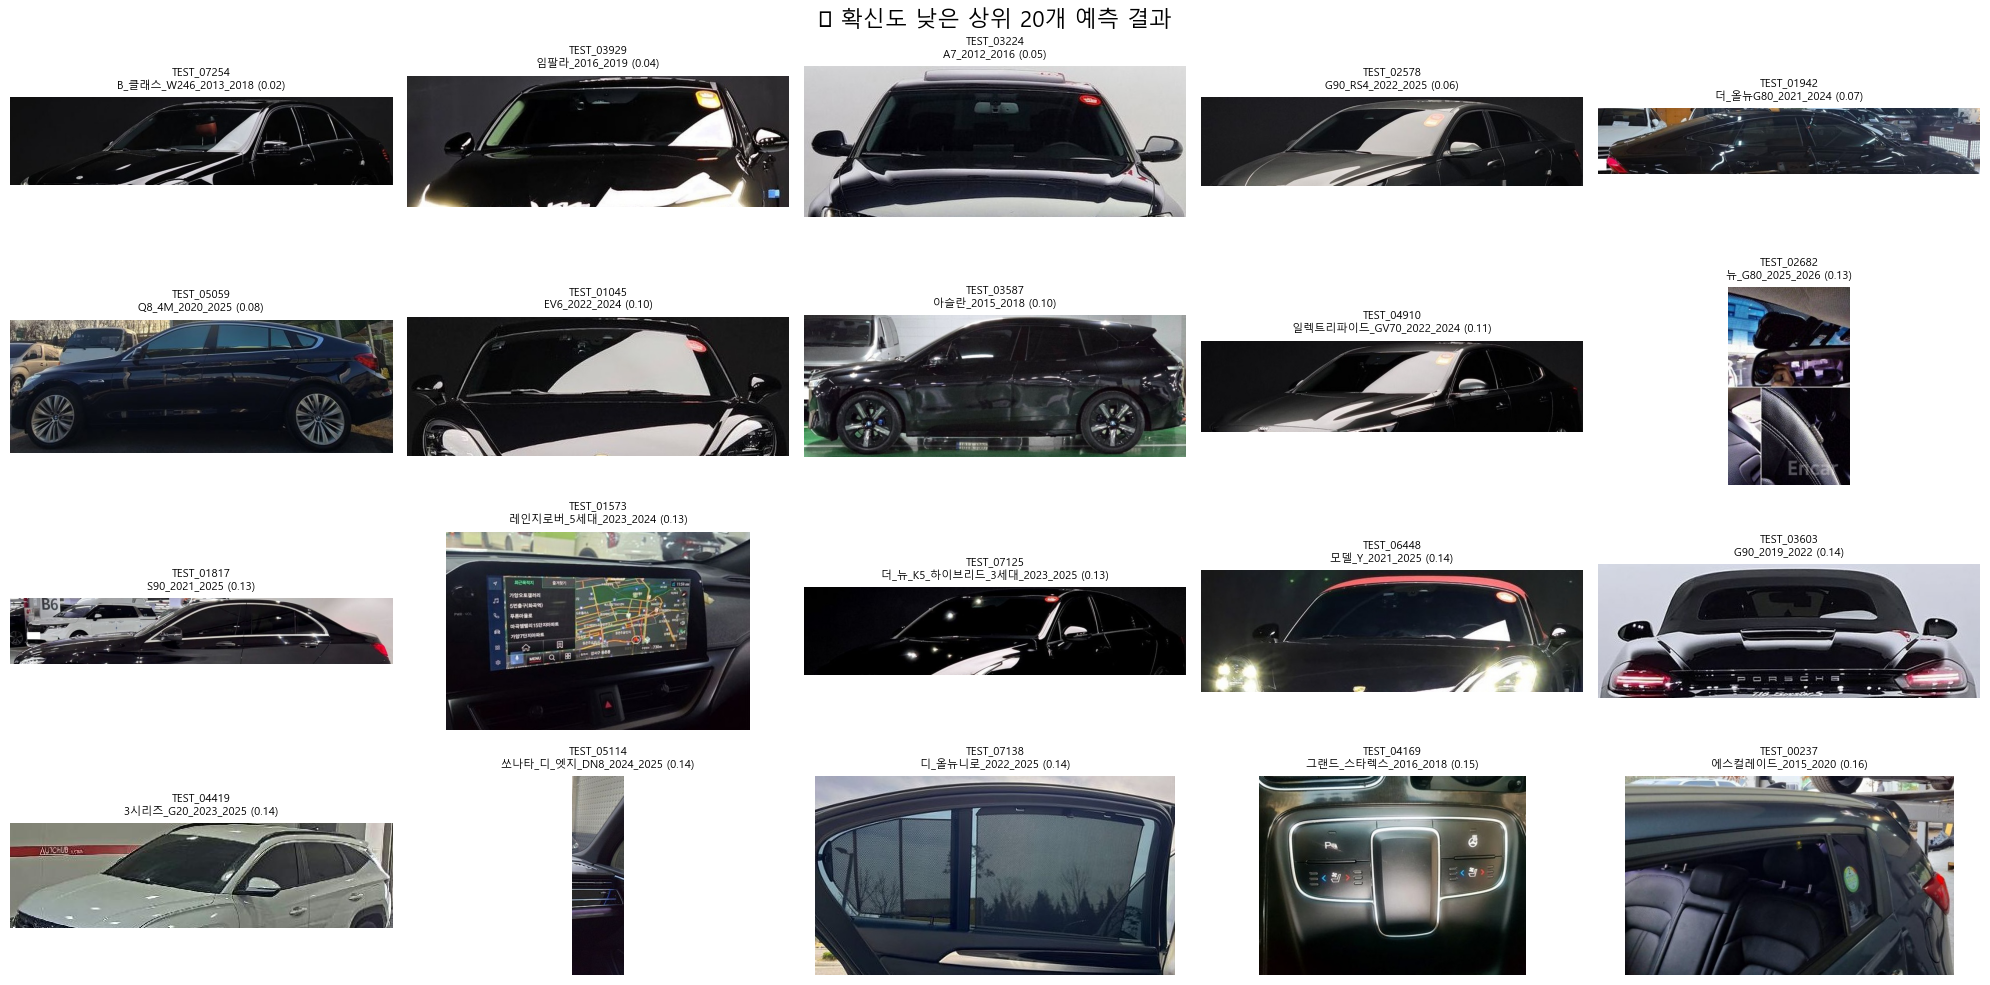

In [3]:
import matplotlib.pyplot as plt
# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False


# ✅ 확신도 계산
probs = np.array(results)  # shape: (num_samples, num_classes)
confidences = probs.max(axis=1)  # 각 샘플의 최고 확률값

# 확신도 낮은 20개 인덱스
low_conf_indices = np.argsort(confidences)[:20]

# 시각화
plt.figure(figsize=(20, 10))
for i, idx in enumerate(low_conf_indices):
    img_path = os.path.join('../data', test_df.loc[idx, 'img_path'])
    image = Image.open(img_path).convert('RGB')

    plt.subplot(4, 5, i + 1)
    plt.imshow(image)
    plt.axis('off')
    
    pred_label = class_names[np.argmax(probs[idx])]
    plt.title(f"{test_df.loc[idx, 'ID']}\n{pred_label} ({confidences[idx]:.2f})", fontsize=8)

plt.suptitle("🔍 확신도 낮은 상위 20개 예측 결과", fontsize=16)
plt.tight_layout()
plt.show()


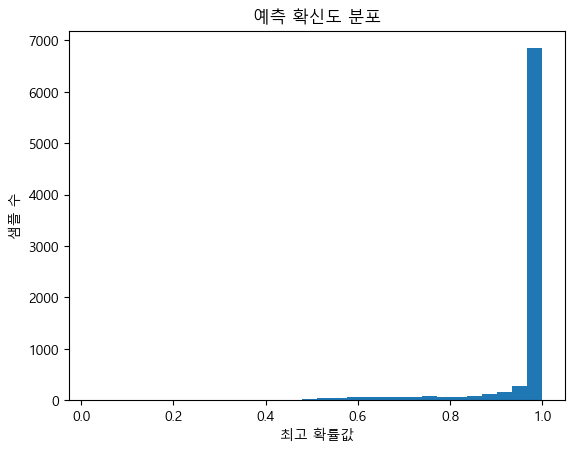

In [4]:
plt.hist(confidences, bins=30)
plt.title("예측 확신도 분포")
plt.xlabel("최고 확률값")
plt.ylabel("샘플 수")
plt.show()


In [8]:
import numpy as np
import pandas as pd

# 확신도 및 예측 결과
y_pred = np.argmax(probs, axis=1)
confidences = np.max(probs, axis=1)
num_classes = probs.shape[1]

# 클래스별 확신도 평균 저장
class_conf_avg = {}

for class_idx in range(num_classes):
    indices = np.where(y_pred == class_idx)[0]  # 해당 클래스로 예측된 샘플
    if len(indices) == 0:
        class_conf_avg[class_idx] = np.nan  # 예측된 샘플이 없으면 NaN 처리
    else:
        class_conf_avg[class_idx] = np.mean(confidences[indices])

# DataFrame으로 정리 후 정렬
conf_df = pd.DataFrame({
    'class_idx': list(class_conf_avg.keys()),
    'avg_confidence': list(class_conf_avg.values()),
    'class_name': [class_names[i] for i in class_conf_avg.keys()]
}).dropna()

conf_df_sorted = conf_df.sort_values(by='avg_confidence').head(20)
conf_df_sorted

,class_idx,avg_confidence,class_name
15,15,0.559944,4시리즈_G22_2024_2025
381,381,0.651219,트레일블레이저_2023
335,335,0.738128,올_뉴_K7_2016_2019
99,99,0.741145,K8_2022_2024
277,277,0.748305,레인지로버_이보크_2세대_2023_2024
98,98,0.751535,K7_프리미어_하이브리드_2020_2021
97,97,0.780462,K7_프리미어_2020_2021
171,171,0.787661,그랜드_스타렉스_2016_2018
319,319,0.787848,아반떼_하이브리드_CN7_2021_2023
210,210,0.788332,더_뉴_K5_3세대_2024_2025
